In [1]:
## Prework: Stage Environment

import csv
import pydot
import pydotplus
import warnings
import numpy as np
import pandas as pd
import graphviz as gv
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
## Load Initial Datasets
S0Data = pd.read_csv('S0Data.csv')
S1Data = pd.read_csv('S1Data.csv')
S6Data = pd.read_csv('S6Data.csv')
SAData = pd.read_csv('SAData.csv')

## Isolate Variables of Interest from Datasets
S0Data = S0Data[['S0NEARPRO']]
S1Data = S1Data[['S1PROJUS_PJPOLI', 'S1PROJUS_PJPNUM', 'S1PSMI', 'S1EXPTOT']]
S6Data = S6Data[['S6PROJUS_PJPOLI', 'S6PROJUS_PJPNUM', 'S6PSMI', 'S6EXPTOT']]
SAData = SAData[['SAPROJUS_PJPOLI', 'SAPROJUS_PJPNUM', 'SAPSMI', 'SAEXPTOT']]

## Create Dataset
Allmonth = pd.concat([S0Data, S1Data, S6Data, SAData], axis=1, sort=False)

## Create set variants & clean the data
# Modified Dataset 1: Skip pattern present in variable S#PROJUS_PJPNUM edited to reflect accurate instances of police contact (i.e., '0'); other skip-patterns replaced to reflect missing values
Allmonth = Allmonth.replace([-202, -201, -700, -300, -9, -8], np.nan)
Allmonth = Allmonth.replace({'S1PROJUS_PJPNUM': -101,
                            'S6PROJUS_PJPNUM': -101,
                            'SAPROJUS_PJPNUM': -101}, 0)
## The na_values indicate the following:
##      -202: Partial interview, data missing
##      -201: Missed interview
##      -700: Data missing due to bug in interview
##      -300: Too few answers for computation 
##      -9: Didn't Know
##      -8: Refused
##      -101: Not picked up by police during recall period (NOTE: This particular N/A value was a skip pattern and possesses an actual value of '0' (i.e., "was picked up by the police 0 times during the recall period") and was thus replaced by '0' and not 'NaN' during the data cleaning process.) 


# Modified Dataset 2: All 'NA' values dropped from observations.
AllmonthNA = Allmonth.dropna()

# Modified Dataset 3: Collapsing observations for the purposes of predictive modeling
AllcollapseNA = AllmonthNA.replace({'S1PROJUS_PJPNUM': {5 : 4, 6 : 4, 7 : 4},
                                   'S6PROJUS_PJPNUM': {5 : 4, 6 : 4, 7 : 4},
                                   'SAPROJUS_PJPNUM': {5 : 4, 6 : 4, 15 : 4}})

# Modified Dataset 5: Creating Select Models for Police Contact
S1PolConOnlyraw = AllcollapseNA.drop(AllcollapseNA[AllcollapseNA.S1PROJUS_PJPOLI == 0].index)
S1PolConOnly = S1PolConOnlyraw.dropna()
S6PolConOnlyraw = AllcollapseNA.drop(AllcollapseNA[AllcollapseNA.S6PROJUS_PJPOLI == 0].index)
S6PolConOnly = S6PolConOnlyraw.dropna()
SAPolConOnlyraw = AllcollapseNA.drop(AllcollapseNA[AllcollapseNA.SAPROJUS_PJPOLI == 0].index)
SAPolConOnly = SAPolConOnlyraw.dropna()

In [3]:
# Generating table of summary statistics for all items in dataset
Allmonthstats = Allmonth.dropna()
Allmonthstats.describe()

,S0NEARPRO,S1PROJUS_PJPOLI,S1PROJUS_PJPNUM,S1PSMI,S1EXPTOT,S6PROJUS_PJPOLI,S6PROJUS_PJPNUM,S6PSMI,S6EXPTOT,SAPROJUS_PJPOLI,SAPROJUS_PJPNUM,SAPSMI,SAEXPTOT
count,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.00000,949.000000,949.000000
mean,1.516333,0.188620,0.250790,3.049989,1.423604,0.194942,0.249737,3.185753,0.905163,0.234984,0.31823,3.283014,1.088514
std,1.195542,0.391412,0.646568,0.466635,1.880870,0.396365,0.596944,0.463799,1.512767,0.424213,0.79416,0.425520,1.679664
min,0.000000,0.000000,0.000000,1.100000,0.000000,0.000000,0.000000,1.830000,0.000000,0.000000,0.00000,1.200000,0.000000
25%,1.000000,0.000000,0.000000,2.770000,0.000000,0.000000,0.000000,2.870000,0.000000,0.000000,0.00000,2.970000,0.000000
50%,2.000000,0.000000,0.000000,3.030000,1.000000,0.000000,0.000000,3.130000,0.000000,0.000000,0.00000,3.300000,0.000000
75%,2.000000,0.000000,0.000000,3.400000,2.000000,0.000000,0.000000,3.600000,1.000000,0.000000,0.00000,3.630000,2.000000
max,5.000000,1.000000,7.000000,4.000000,10.000000,1.000000,5.000000,4.000000,10.000000,1.000000,15.00000,4.000000,10.000000


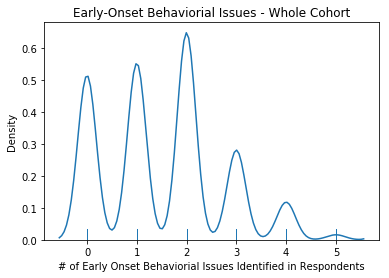

Frequencies: [(0, 328), (1, 352), (2, 411), (3, 178), (4, 75), (5, 10)]


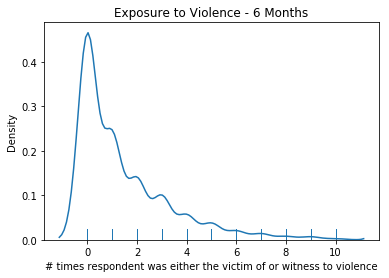

Frequencies: [(0.0, 550), (1.0, 273), (2.0, 158), (3.0, 114), (4.0, 64), (5.0, 43), (6.0, 23), (7.0, 16), (8.0, 9), (9.0, 8), (10.0, 3)]


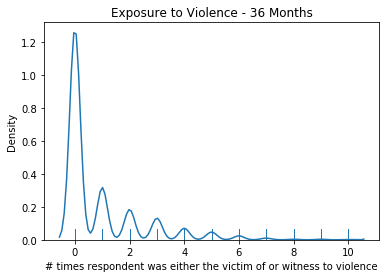

Frequencies: [(0.0, 765), (1.0, 186), (2.0, 109), (3.0, 78), (4.0, 41), (5.0, 28), (6.0, 14), (7.0, 6), (8.0, 2), (9.0, 2), (10.0, 1)]


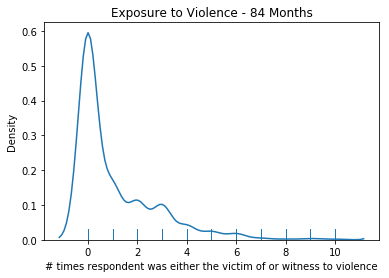

Frequencies: [(0.0, 646), (1.0, 163), (2.0, 116), (3.0, 106), (4.0, 43), (5.0, 25), (6.0, 19), (7.0, 5), (8.0, 2), (9.0, 4), (10.0, 2)]


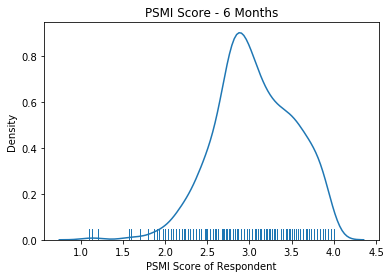

Frequencies: [(1.1, 1), (1.13, 1), (1.2, 1), (1.57, 1), (1.6, 2), (1.7, 1), (1.8, 1), (1.87, 3), (1.9, 2), (1.93, 1), (1.97, 1), (2.0, 4), (2.03, 2), (2.07, 1), (2.1, 4), (2.13, 4), (2.17, 5), (2.2, 11), (2.22, 1), (2.23, 4), (2.24, 1), (2.27, 7), (2.3, 8), (2.33, 6), (2.37, 9), (2.4, 16), (2.43, 14), (2.47, 13), (2.48, 1), (2.5, 19), (2.53, 13), (2.57, 24), (2.59, 1), (2.6, 13), (2.63, 19), (2.67, 19), (2.69, 1), (2.7, 34), (2.72, 1), (2.73, 30), (2.76, 2), (2.77, 38), (2.8, 47), (2.83, 41), (2.85, 1), (2.86, 2), (2.87, 41), (2.9, 43), (2.93, 31), (2.97, 38), (3.0, 40), (3.03, 39), (3.07, 27), (3.08, 1), (3.1, 27), (3.13, 30), (3.14, 2), (3.17, 27), (3.2, 29), (3.21, 1), (3.23, 18), (3.24, 1), (3.27, 27), (3.29, 1), (3.3, 26), (3.33, 26), (3.37, 17), (3.4, 29), (3.43, 20), (3.45, 1), (3.47, 23), (3.48, 1), (3.5, 25), (3.53, 23), (3.55, 1), (3.57, 21), (3.6, 21), (3.63, 20), (3.67, 14), (3.68, 1), (3.7, 23), (3.73, 17), (3.77, 14), (3.8, 17), (3.83, 17), (3.87, 10), (3.9, 32), (3.93, 1

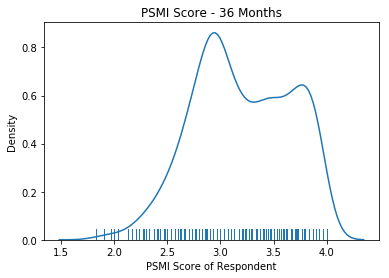

Frequencies: [(1.83, 1), (1.9, 2), (1.97, 2), (2.0, 1), (2.03, 2), (2.13, 1), (2.17, 4), (2.2, 4), (2.23, 1), (2.27, 5), (2.28, 1), (2.3, 2), (2.33, 9), (2.37, 3), (2.4, 8), (2.41, 1), (2.43, 7), (2.47, 10), (2.48, 1), (2.5, 8), (2.53, 14), (2.57, 13), (2.6, 11), (2.62, 1), (2.63, 18), (2.66, 1), (2.67, 19), (2.7, 24), (2.73, 23), (2.76, 2), (2.77, 23), (2.8, 35), (2.83, 26), (2.85, 1), (2.86, 1), (2.87, 30), (2.9, 50), (2.93, 32), (2.97, 65), (3.0, 35), (3.03, 29), (3.07, 23), (3.1, 28), (3.13, 24), (3.17, 26), (3.2, 24), (3.21, 1), (3.23, 18), (3.24, 1), (3.27, 22), (3.29, 1), (3.3, 24), (3.33, 18), (3.34, 1), (3.37, 16), (3.4, 32), (3.41, 2), (3.43, 22), (3.45, 1), (3.47, 18), (3.48, 1), (3.5, 40), (3.53, 24), (3.55, 1), (3.57, 12), (3.59, 2), (3.6, 19), (3.62, 1), (3.63, 21), (3.66, 1), (3.67, 19), (3.7, 39), (3.71, 1), (3.72, 1), (3.73, 24), (3.77, 23), (3.79, 1), (3.8, 31), (3.83, 17), (3.87, 34), (3.9, 66), (3.93, 5), (3.97, 10), (4.0, 6)]


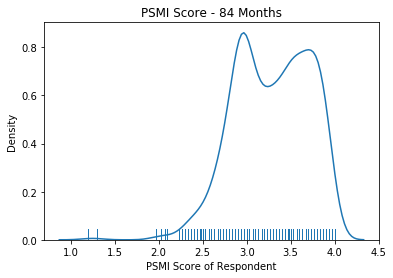

Frequencies: [(1.2, 1), (1.3, 1), (1.97, 1), (2.03, 2), (2.07, 1), (2.1, 1), (2.23, 1), (2.27, 2), (2.3, 3), (2.33, 3), (2.37, 2), (2.4, 6), (2.43, 5), (2.47, 4), (2.48, 1), (2.5, 3), (2.53, 5), (2.57, 8), (2.6, 3), (2.63, 11), (2.67, 16), (2.7, 12), (2.73, 15), (2.77, 16), (2.8, 17), (2.83, 24), (2.87, 33), (2.9, 23), (2.93, 46), (2.97, 73), (3.0, 28), (3.03, 25), (3.07, 25), (3.1, 15), (3.13, 24), (3.17, 24), (3.2, 19), (3.23, 28), (3.27, 21), (3.3, 26), (3.33, 27), (3.37, 22), (3.4, 22), (3.43, 24), (3.47, 26), (3.48, 1), (3.5, 34), (3.53, 34), (3.57, 30), (3.6, 25), (3.63, 31), (3.67, 21), (3.7, 32), (3.73, 38), (3.77, 25), (3.8, 39), (3.83, 26), (3.87, 25), (3.9, 50), (3.93, 14), (3.97, 4), (4.0, 5)]


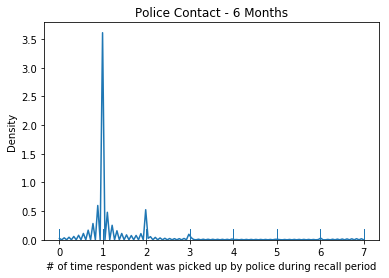

Frequencies: [(0.0, 1030), (1.0, 185), (2.0, 33), (3.0, 8), (4.0, 1), (5.0, 1), (6.0, 2), (7.0, 1)]


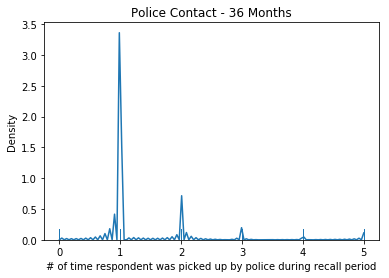

Frequencies: [(0.0, 985), (1.0, 205), (2.0, 28), (3.0, 8), (4.0, 3), (5.0, 3)]


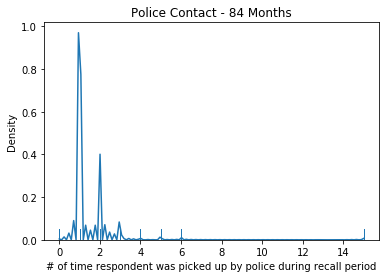

Frequencies: [(0.0, 878), (1.0, 202), (2.0, 35), (3.0, 12), (4.0, 1), (5.0, 2), (6.0, 1), (15.0, 1)]


In [4]:
## Distribution of Variables: Distribution Plots

# Define function to generate distribution plots, render them in Notebook, and export them as an image file for a given variable
def distplotgen(variable, xlabel, title, output):
    variable_clean = variable.dropna()
    fig = plt.figure()
    sns.distplot(variable_clean, hist=False, rug=True);
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)
    fig.savefig(output + '.png')
    plt.show()
    counted = Counter(variable_clean)
    print("Frequencies:", sorted(counted.items()))

#Early-Onset Behavioral Issues
distplotgen(Allmonth.S0NEARPRO, "# of Early Onset Behaviorial Issues Identified in Respondents", "Early-Onset Behaviorial Issues - Whole Cohort", "dplotEOBI.png")

#Exposure to Violence
distplotgen(Allmonth.S1EXPTOT, "# times respondent was either the victim of or witness to violence", "Exposure to Violence - 6 Months", "dplotEXPTOTS1.png")
distplotgen(Allmonth.S6EXPTOT, "# times respondent was either the victim of or witness to violence", "Exposure to Violence - 36 Months", "dplotEXPTOTS6.png")
distplotgen(Allmonth.SAEXPTOT, "# times respondent was either the victim of or witness to violence", "Exposure to Violence - 84 Months", "dplotEXPTOTSA.png")

#Psychosocial Maturity
distplotgen(Allmonth.S1PSMI, "PSMI Score of Respondent", "PSMI Score - 6 Months", "dplotPSMIS1.png")
distplotgen(Allmonth.S6PSMI, "PSMI Score of Respondent", "PSMI Score - 36 Months", "dplotPSMIS6.png")
distplotgen(Allmonth.SAPSMI, "PSMI Score of Respondent", "PSMI Score - 84 Months", "dplotPSMISA.png")

#Police Contact
distplotgen(Allmonth.S1PROJUS_PJPNUM, "# of time respondent was picked up by police during recall period", "Police Contact - 6 Months", "dplotPolConS1.png")
distplotgen(Allmonth.S6PROJUS_PJPNUM, "# of time respondent was picked up by police during recall period", "Police Contact - 36 Months", "dplotPolConS6.png")
distplotgen(Allmonth.SAPROJUS_PJPNUM, "# of time respondent was picked up by police during recall period", "Police Contact - 84 Months", "dplotPolConSA.png")

In [5]:
## Distribution Plots: Gain specific counts for tables corresponding to charts

def countfreq(var, title):
    varclean = var.dropna()
    cnt = Counter(varclean)
    cntdict = dict(cnt)
    cntdf = pd.DataFrame.from_dict(cntdict, orient = 'index').reset_index()
    cntdf = cntdf.sort_values(by=['index'])
    cntdf.to_csv(title + '.csv')
    print(title)
    print(cntdf)

        
countfreq(Allmonth.S0NEARPRO, "Table: S0NEARPRO")

countfreq(Allmonth.S1EXPTOT, "Table: S1EXPTOT")
countfreq(Allmonth.S6EXPTOT, "Table: S6EXPTOT")
countfreq(Allmonth.SAEXPTOT, "Table: SAEXPTOT")

countfreq(Allmonth.S1PSMI, "Table: S1PSMI")
countfreq(Allmonth.S6PSMI, "Table: S6PSMI")
countfreq(Allmonth.SAPSMI, "Table: SAPSMI")

countfreq(Allmonth.S1PROJUS_PJPNUM, "Table: S1PROJUS")
countfreq(Allmonth.S6PROJUS_PJPNUM, "Table: S6PROJUS")
countfreq(Allmonth.SAPROJUS_PJPNUM, "Table: SAPROJUS")

Table: S0NEARPRO
   index    0
0      0  328
2      1  352
1      2  411
3      3  178
4      4   75
5      5   10
Table: S1EXPTOT
    index    0
0     0.0  550
4     1.0  273
6     2.0  158
3     3.0  114
2     4.0   64
7     5.0   43
5     6.0   23
9     7.0   16
1     8.0    9
8     9.0    8
10   10.0    3
Table: S6EXPTOT
    index    0
0     0.0  765
1     1.0  186
2     2.0  109
4     3.0   78
6     4.0   41
5     5.0   28
3     6.0   14
9     7.0    6
7     8.0    2
8     9.0    2
10   10.0    1
Table: SAEXPTOT
    index    0
1     0.0  646
0     1.0  163
2     2.0  116
3     3.0  106
4     4.0   43
7     5.0   25
8     6.0   19
5     7.0    5
10    8.0    2
6     9.0    4
9    10.0    2
Table: S1PSMI
    index   0
70   1.10   1
82   1.13   1
87   1.20   1
89   1.57   1
74   1.60   2
66   1.70   1
81   1.80   1
71   1.87   3
68   1.90   2
77   1.93   1
78   1.97   1
76   2.00   4
56   2.03   2
88   2.07   1
73   2.10   4
46   2.13   4
43   2.17   5
50   2.20  11
58   2.22   1
63 

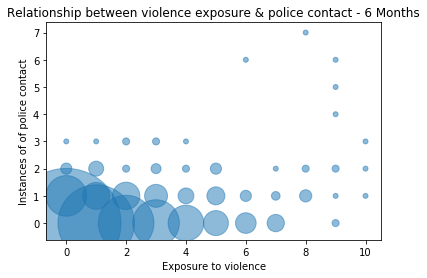

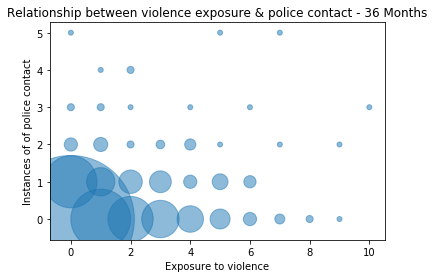

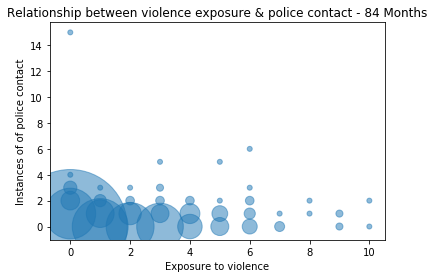

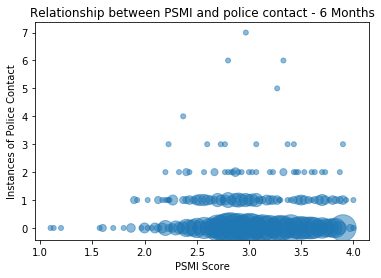

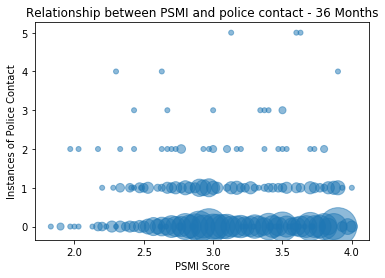

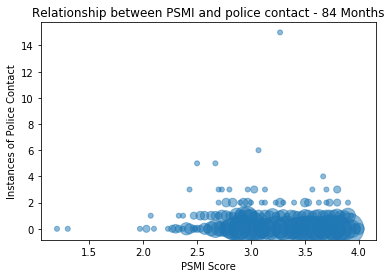

In [6]:
## Bubble Plots

# Define function to create bubble plots, render them in Notebook, and save them to working directory
def bubbleplot(df, variable1, variable2, xlabel, ylabel, title, output):
    count = 0
    x_vals = []
    y_vals = []
    bsize = []
    for i in variable1.unique():
        for j in variable2.unique():
            bubblesize = len(df[(variable1 == i) & (variable2 == j)])
            count += bubblesize
            x_vals.append(i)
            y_vals.append(j)
            bsize.append(bubblesize)
    ctbsize = Counter(bsize)
    ctbsize = dict(ctbsize)
    ctbsize = pd.DataFrame.from_dict(ctbsize, orient = 'index').reset_index()
    ctbsize = ctbsize.sort_values(by=['index'])
    ctbsize.to_csv('Bubble Frequencies' + output + '.csv')
    bsizescale = [n*25 for n in bsize]
    fig = plt.figure()
    plt.scatter(x_vals, y_vals, s=bsizescale, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    fig.savefig('bplot' + output + '.png')
    plt.show()
    
# Bubbleplots testing for correlation between exposure to violence & police contact
bubbleplot(Allmonth, Allmonth.S1EXPTOT, Allmonth.S1PROJUS_PJPNUM, "Exposure to violence", "Instances of of police contact", "Relationship between violence exposure & police contact - 6 Months", "EXPTOTS1")
bubbleplot(Allmonth, Allmonth.S6EXPTOT, Allmonth.S6PROJUS_PJPNUM, "Exposure to violence", "Instances of of police contact", "Relationship between violence exposure & police contact - 36 Months", "EXPTOTS6")
bubbleplot(Allmonth, Allmonth.SAEXPTOT, Allmonth.SAPROJUS_PJPNUM, "Exposure to violence", "Instances of of police contact", "Relationship between violence exposure & police contact - 84 Months", "EXPTOTSA")


# Bubbleplots testing for correlation between PSMI and police contact
bubbleplot(Allmonth, Allmonth.S1PSMI, Allmonth.S1PROJUS_PJPNUM, "PSMI Score", "Instances of Police Contact", "Relationship between PSMI and police contact - 6 Months", "PSMIS1")
bubbleplot(Allmonth, Allmonth.S6PSMI, Allmonth.S6PROJUS_PJPNUM, "PSMI Score", "Instances of Police Contact", "Relationship between PSMI and police contact - 36 Months", "PSMIS6")
bubbleplot(Allmonth, Allmonth.SAPSMI, Allmonth.SAPROJUS_PJPNUM, "PSMI Score", "Instances of Police Contact", "Relationship between PSMI and police contact - 84 Months", "PSMISA")



In [7]:
## Predictive Modeling Prework: KNN Classification Model

# Creating a Feature Matrix & Target Array for 6-Month Cohort
XvaluesS1 = AllcollapseNA.drop(['S1PROJUS_PJPNUM', 'S1PROJUS_PJPOLI', 
                                'S6PROJUS_PJPOLI', 'S6PROJUS_PJPNUM', 'S6PSMI', 'S6EXPTOT',
                                'SAPROJUS_PJPOLI', 'SAPROJUS_PJPNUM', 'SAPSMI', 'SAEXPTOT'], axis=1)
PolConS1 = AllcollapseNA.S1PROJUS_PJPNUM

# QA: print('X shape:', XvaluesS1.shape, '\ny shape:', PolConS1.shape)

# Converting y values to string type variable
PolConS1 = PolConS1.astype(str)

## Testing for appropriate value of k and generating accuracy scores
#  Defining a function to test for optimal k-value and accuracy score generator
def kvaluecv(list_of_k, cvfold, xparam, yparam):
    for k in list_of_k:
        KNN = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(KNN, xparam, yparam, cv=cvfold)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

kvaluecv([1, 3, 5, 7, 10], 3, XvaluesS1, PolConS1)

# Create & fit the model for the 6-month cohort using appropriate k value
KNNmodelS1 = KNeighborsClassifier(n_neighbors=5)

KNNmodelS1.fit(XvaluesS1, PolConS1)

Accuracy: 0.68 (+/- 0.04)
Accuracy: 0.77 (+/- 0.01)
Accuracy: 0.79 (+/- 0.02)
Accuracy: 0.81 (+/- 0.00)
Accuracy: 0.81 (+/- 0.00)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [8]:
## Predictive Modeling Prework: KNN Classification Model

#Creating Feature Matrix & Target Array for 36-Month Cohort
XvaluesS6 = AllcollapseNA.drop(['S6PROJUS_PJPNUM', 'S6PROJUS_PJPOLI', 
                                'S1PROJUS_PJPOLI', 'S1PROJUS_PJPNUM', 'S1PSMI', 'S1EXPTOT',
                                'SAPROJUS_PJPOLI', 'SAPROJUS_PJPNUM', 'SAPSMI', 'SAEXPTOT'], axis=1)
PolConS6 = AllcollapseNA.S6PROJUS_PJPNUM

# QA: print('X shape:', XvaluesS6.shape, '\ny shape:', PolConS6.shape)

#Converting y values to string type variable
PolConS6 = PolConS6.astype(str)

## KNN Classification Model -- Testing for appropriate value of k and generating accuracy scores
kvaluecv([1, 3, 5, 7, 10], 3, XvaluesS6, PolConS6)

# Create & fit the model using appropriate k value
KNNmodelS6 = KNeighborsClassifier(n_neighbors=5)

KNNmodelS6.fit(XvaluesS6, PolConS6)

Accuracy: 0.67 (+/- 0.04)
Accuracy: 0.77 (+/- 0.01)
Accuracy: 0.78 (+/- 0.03)
Accuracy: 0.79 (+/- 0.01)
Accuracy: 0.80 (+/- 0.01)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [9]:
## Predictive Modeling Prework: KNN Classification Model
# Creating Feature Matrix & Target Array for 36-Month Cohort

XvaluesSA = AllcollapseNA.drop(['SAPROJUS_PJPNUM', 'SAPROJUS_PJPOLI', 
                                'S1PROJUS_PJPOLI', 'S1PROJUS_PJPNUM', 'S1PSMI', 'S1EXPTOT',
                                'S6PROJUS_PJPOLI', 'S6PROJUS_PJPNUM', 'S6PSMI', 'S6EXPTOT'], axis=1)
PolConSA = AllcollapseNA.S6PROJUS_PJPNUM

# QA: print('X shape:', XvaluesSA.shape, '\ny shape:', PolConSA.shape)

# Converting y values to string type variable
PolConSA = PolConSA.astype(str)

# Testing for appropriate value of k and generating accuracy scores

kvaluecv([1, 3, 5, 7, 10], 3, XvaluesSA, PolConSA)

# Create & fit the model using appropriate k value

KNNmodelSA = KNeighborsClassifier(n_neighbors=5)

KNNmodelSA.fit(XvaluesSA, PolConSA)

Accuracy: 0.67 (+/- 0.03)
Accuracy: 0.76 (+/- 0.02)
Accuracy: 0.79 (+/- 0.02)
Accuracy: 0.79 (+/- 0.01)
Accuracy: 0.80 (+/- 0.01)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [10]:
## Decision Tree Model
# Create & fit the model for 6-month cohort

TreemodelS1 = tree.DecisionTreeClassifier()

TreemodelS1.fit(XvaluesS1, PolConS1)

# 36-month cohort
TreemodelS6 = tree.DecisionTreeClassifier()

TreemodelS6.fit(XvaluesS6, PolConS6)

# 84-month cohort
TreemodelSA = tree.DecisionTreeClassifier()

TreemodelSA.fit(XvaluesSA, PolConSA)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [11]:
## Decision Tree Model
# Define function to test accuracy of model
def crossvaltest(model, featurevar, targetvar, cvfold, modelname):
    scores = cross_val_score(model, featurevar, targetvar, cv=cvfold)
    print(modelname + " Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# Test Accuracy of models

# 6 months
crossvaltest(TreemodelS1, XvaluesS1, PolConS1, 3, 'TS1')

# 36 months
crossvaltest(TreemodelS6, XvaluesS6, PolConS6, 3, 'TS6')

# 84 months
crossvaltest(TreemodelSA, XvaluesSA, PolConSA, 3, 'TSA')

TS1 Accuracy: 0.71 (+/- 0.03)
TS6 Accuracy: 0.72 (+/- 0.01)
TSA Accuracy: 0.71 (+/- 0.03)


In [12]:
# Create Random Forest Model - 6 month cohort
RandommodelS1 = RandomForestClassifier(n_estimators = 1000,
                                      random_state = 0)

RandommodelS1.fit(XvaluesS1, PolConS1)

# 36 months
RandommodelS6 = RandomForestClassifier(n_estimators = 1000,
                                      random_state = 0)

RandommodelS6.fit(XvaluesS6, PolConS6)

# 84 months
RandommodelSA = RandomForestClassifier(n_estimators = 1000,
                                      random_state = 0)

RandommodelSA.fit(XvaluesSA, PolConSA)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [13]:
# Test 
crossvaltest(RandommodelS1, XvaluesS1, PolConS1, 3, 'RM1')
crossvaltest(RandommodelS6, XvaluesS6, PolConS6, 3, 'RM6')
crossvaltest(RandommodelSA, XvaluesSA, PolConSA, 3, 'RMA')

RM1 Accuracy: 0.74 (+/- 0.02)
RM6 Accuracy: 0.74 (+/- 0.00)
RMA Accuracy: 0.74 (+/- 0.01)


In [14]:
# Create and store visualization of random example tree from Random Forest model

tree.export_graphviz(RandommodelS1.estimators_[0], out_file='RFtree.dot')
(graph,) = pydot.graph_from_dot_file('RFtree.dot')
graph.write_png('RFtree.png')

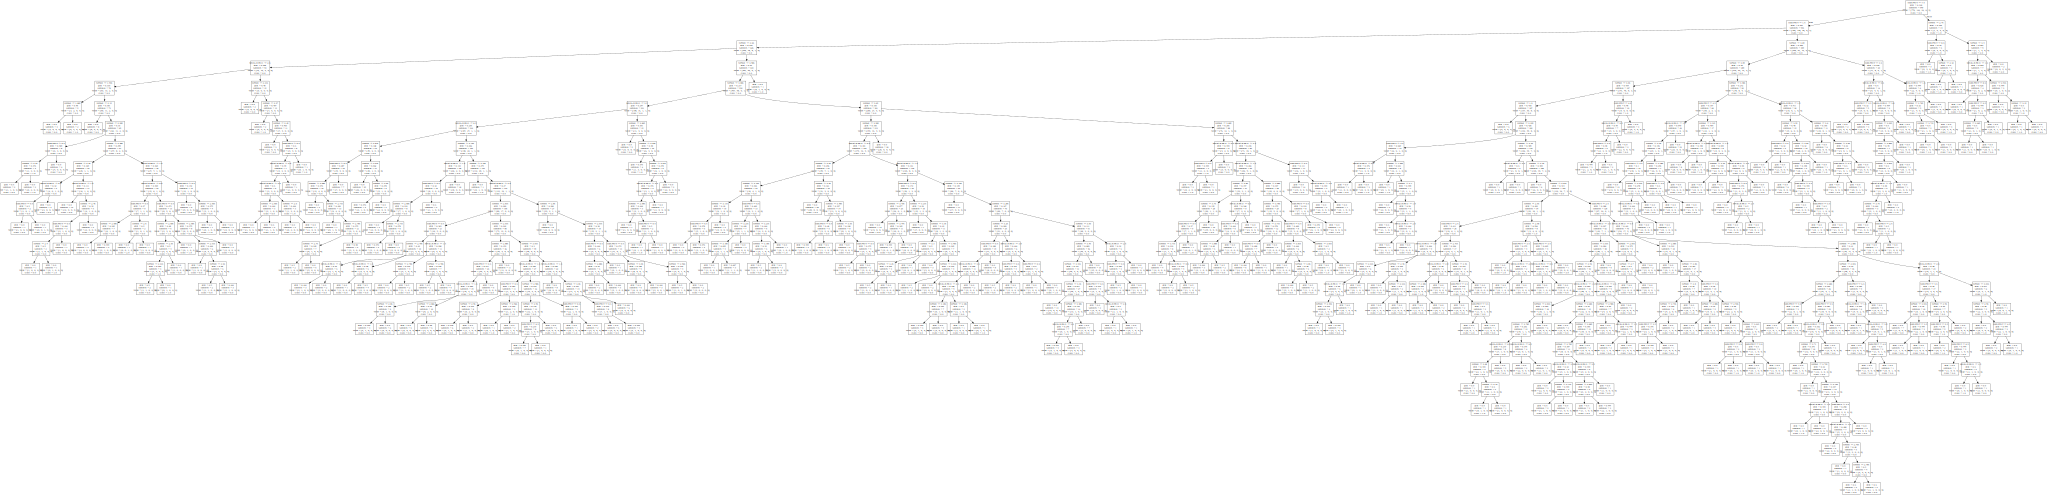

In [15]:
## Decision Tree Model
# Create and Render Visualization of Decision Tree - 6-month cohort

def treeplot(model, xvar, yvar, GraphName):
    dot_data = tree.export_graphviz(model, out_file = None, 
                                    feature_names = xvar.columns, 
                                    class_names = np.sort(yvar.unique()))
    graph = gv.Source(dot_data)
    graph.render(GraphName)
    return graph

graph = treeplot(TreemodelS1, XvaluesS1, PolConS1, "OriginalModelS1")
graph

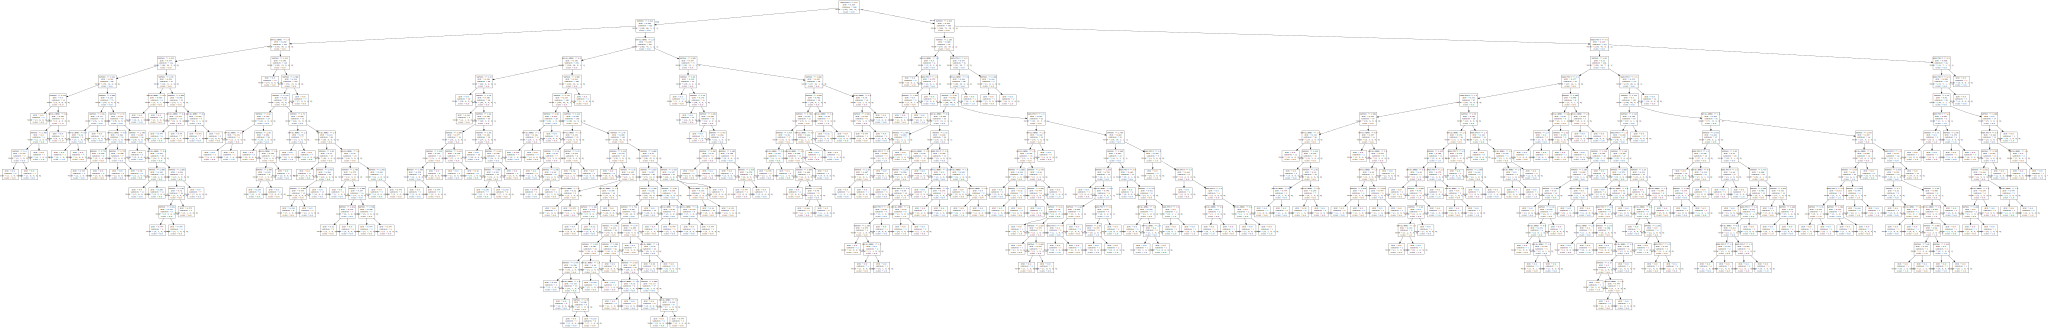

In [16]:
## Decision Tree Model
# Create and Render Visualization of Decision Tree - 36-month cohort

graph = treeplot(TreemodelS6, XvaluesS6, PolConS6, "OriginalModelS6")
graph 
# dot_data = tree.export_graphviz(TreemodelS6, out_file=None,
#                               feature_names=XvaluesS6.columns,
#                               class_names=np.sort(PolConS6.unique()))
# graph = gv.Source(dot_data)
# graph.render("OriginalModelS6")
# graph

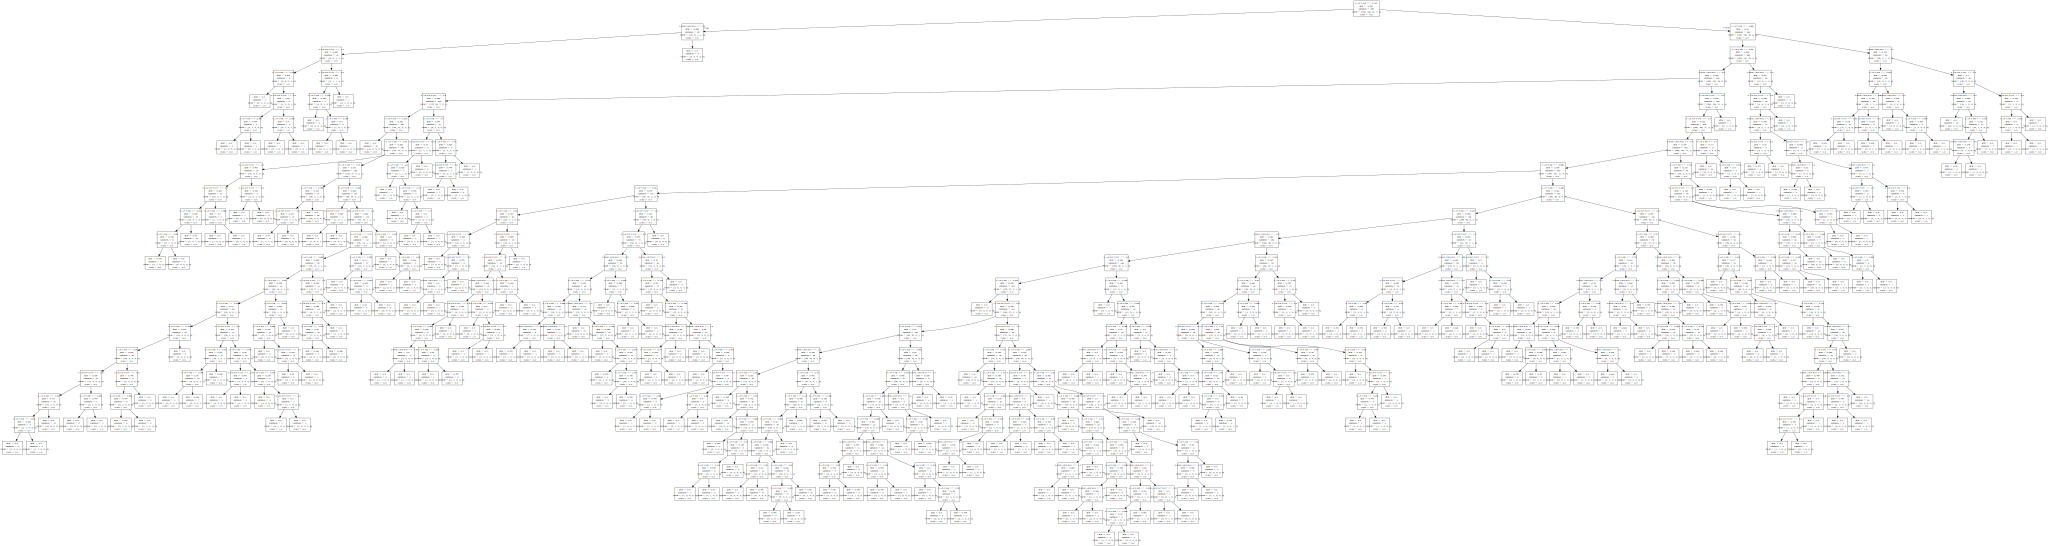

In [17]:
## Decision Tree Model
# Create and Render Visualization of Decision Tree - 84-month cohort

graph = treeplot(TreemodelSA, XvaluesSA, PolConSA, "OriginalModelSA")
graph

# dot_data = tree.export_graphviz(TreemodelSA, out_file=None,
#                                feature_names=XvaluesSA.columns,
#                                class_names=np.sort(PolConSA.unique()))
# graph = gv.Source(dot_data)
# graph.render("OriginalModelSA")
# graph

           Importance       Name
S0NEARPRO    0.209718  S0NEARPRO
S1EXPTOT     0.288387   S1EXPTOT
S1PSMI       0.501895     S1PSMI
           Importance       Name
S6EXPTOT      0.19323   S6EXPTOT
S0NEARPRO     0.31026  S0NEARPRO
S6PSMI        0.49651     S6PSMI
           Importance       Name
S0NEARPRO    0.177923  S0NEARPRO
SAEXPTOT     0.245807   SAEXPTOT
SAPSMI       0.576270     SAPSMI


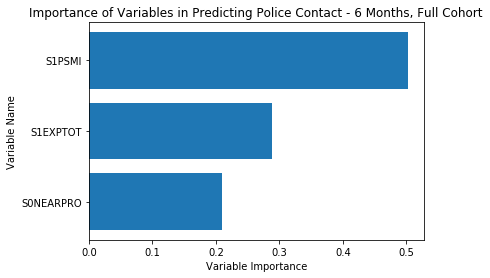

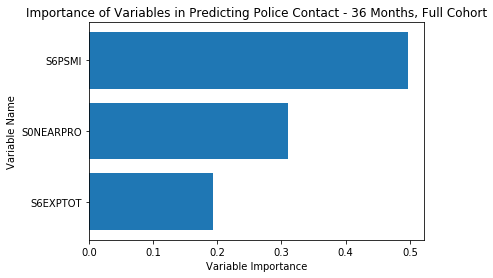

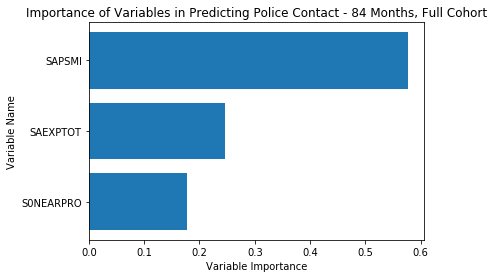

In [18]:
## Feature Importances
# Define function to generate feature importances

def featimpbar(model, featurevar, title):
    # Generate Feature Importance Values
    Vdf_dict = dict(zip(featurevar.columns, model.feature_importances_))
    # Create DataFrame using values
    Vdf = pd.DataFrame.from_dict(Vdf_dict, orient = 'index')
    Vdf['VarName'] = Vdf.index
    Vdf.columns = 'Importance', 'Name'
    Vdf = Vdf.sort_values(by=['Importance', 'Name'])
    # Make barplot for feature importances
    fig = plt.figure()
    plt.barh(Vdf.Name, Vdf.Importance)
    plt.xlabel('Variable Importance')
    plt.ylabel('Variable Name')
    plt.title(title)
    fig.savefig('featplot' + title + '.png')
    Vdf.to_csv('FImportance' + title + '.csv')
    print(Vdf)


# Barplot for full models
featimpbar(TreemodelS1, XvaluesS1, 'Importance of Variables in Predicting Police Contact - 6 Months, Full Cohort')
featimpbar(TreemodelS6, XvaluesS6, 'Importance of Variables in Predicting Police Contact - 36 Months, Full Cohort')
featimpbar(TreemodelSA, XvaluesSA, 'Importance of Variables in Predicting Police Contact - 84 Months, Full Cohort')

           Importance       Name
S0NEARPRO    0.103897  S0NEARPRO
S1EXPTOT     0.235388   S1EXPTOT
S1PSMI       0.660715     S1PSMI
           Importance       Name
S0NEARPRO    0.121861  S0NEARPRO
S6EXPTOT     0.193292   S6EXPTOT
S6PSMI       0.684848     S6PSMI
           Importance       Name
S0NEARPRO    0.111058  S0NEARPRO
SAEXPTOT     0.150381   SAEXPTOT
SAPSMI       0.738561     SAPSMI


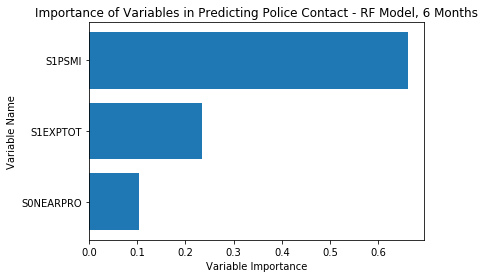

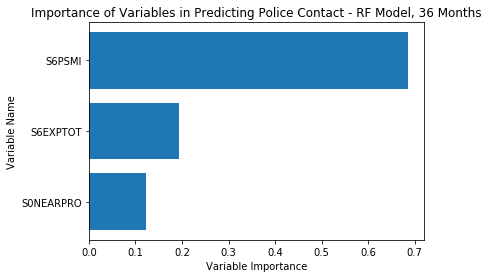

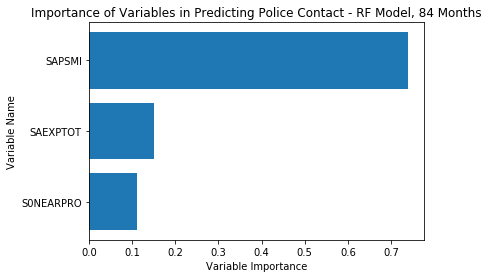

In [19]:
# Feature Importance Graphs of Random Forest model - General cohort
featimpbar(RandommodelS1, XvaluesS1, 'Importance of Variables in Predicting Police Contact - RF Model, 6 Months')
featimpbar(RandommodelS6, XvaluesS6, 'Importance of Variables in Predicting Police Contact - RF Model, 36 Months')
featimpbar(RandommodelSA, XvaluesSA, 'Importance of Variables in Predicting Police Contact - RF Model, 84 Months')

In [20]:
## Target Array and Feature Matrices for Police Contact Sample Only ("Select Model")

# 6-month cohort
XselectS1 = S1PolConOnlyraw.drop(['S1PROJUS_PJPNUM', 'S1PROJUS_PJPOLI', 
                               'S6PROJUS_PJPOLI', 'S6PROJUS_PJPNUM', 'S6PSMI', 'S6EXPTOT', 
                               'SAPROJUS_PJPOLI', 'SAPROJUS_PJPNUM', 'SAPSMI', 'SAEXPTOT'], axis=1)
PolConSelectS1 = S1PolConOnlyraw.S1PROJUS_PJPNUM
PolConSelectS1 = PolConSelectS1.astype(str)
print('X shape:', XselectS1.shape, '\ny shape:', PolConSelectS1.shape)

# 36-month cohort
XselectS6 = S6PolConOnlyraw.drop(['S6PROJUS_PJPNUM', 'S6PROJUS_PJPOLI', 
                               'S1PROJUS_PJPOLI', 'S1PROJUS_PJPNUM', 'S1PSMI', 'S1EXPTOT', 
                               'SAPROJUS_PJPOLI', 'SAPROJUS_PJPNUM', 'SAPSMI', 'SAEXPTOT'], axis=1)
PolConSelectS6 = S6PolConOnlyraw.S6PROJUS_PJPNUM
PolConSelectS6 = PolConSelectS6.astype(str)
print('X shape:', XselectS6.shape, '\ny shape:', PolConSelectS6.shape)

# 84-month cohort
XselectSA = SAPolConOnlyraw.drop(['SAPROJUS_PJPNUM', 'SAPROJUS_PJPOLI', 
                               'S1PROJUS_PJPOLI', 'S1PROJUS_PJPNUM', 'S1PSMI', 'S1EXPTOT', 
                               'S6PROJUS_PJPOLI', 'S6PROJUS_PJPNUM', 'S6PSMI', 'S6EXPTOT'], axis=1)
PolConSelectSA = SAPolConOnlyraw.SAPROJUS_PJPNUM
PolConSelectSA = PolConSelectSA.astype(str)
print('X shape:', XselectSA.shape, '\ny shape:', PolConSelectSA.shape)

X shape: (179, 3) 
y shape: (179,)
X shape: (185, 3) 
y shape: (185,)
X shape: (223, 3) 
y shape: (223,)


In [21]:
## Decision Tree Select Model - 6-month cohort
selectmodelS1 = tree.DecisionTreeClassifier()
selectmodelS1.fit(XselectS1, PolConSelectS1)

# 36-month cohort
selectmodelS6 = tree.DecisionTreeClassifier()
selectmodelS6.fit(XselectS6, PolConSelectS6)

# 84-month cohort
selectmodelSA = tree.DecisionTreeClassifier()
selectmodelSA.fit(XselectSA, PolConSelectSA)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
## Cross-Validation & Accuracy Score for Select Models

# 6-month
crossvaltest(selectmodelS1, XselectS1, PolConSelectS1, 3, 'SM1')

# 36-month
crossvaltest(selectmodelS6, XselectS6, PolConSelectS6, 3, 'SM6')

crossvaltest(selectmodelSA, XselectSA, PolConSelectSA, 3, 'SMA')

SM1 Accuracy: 0.72 (+/- 0.05)
SM6 Accuracy: 0.73 (+/- 0.09)
SMA Accuracy: 0.64 (+/- 0.03)


In [23]:
## Random Forest Modeling for Select Model
# 6-month cohort

randomselectS1 = RandomForestClassifier()
randomselectS1.fit(XselectS1, PolConSelectS1)

# 36-month
randomselectS6 = RandomForestClassifier()
randomselectS6.fit(XselectS6, PolConSelectS6)

# 84-month
randomselectSA = RandomForestClassifier()
randomselectSA.fit(XselectSA, PolConSelectSA)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
## Cross-Validation & Accuracy Score for Select RF Models

# 6-month
crossvaltest(randomselectS1, XselectS1, PolConSelectS1, 3, 'RS1')

# 36-month
crossvaltest(randomselectS6, XselectS6, PolConSelectS6, 3, 'RS6')

crossvaltest(randomselectSA, XselectSA, PolConSelectSA, 3, 'RSA')

RS1 Accuracy: 0.78 (+/- 0.08)
RS6 Accuracy: 0.80 (+/- 0.05)
RSA Accuracy: 0.71 (+/- 0.00)


In [25]:
## Create and Store Example Tree from Random Forest Model

tree.export_graphviz(randomselectS1.estimators_[0], out_file='RStree.dot')
(graph,) = pydot.graph_from_dot_file('RStree.dot')
graph.write_png('RStree.png')


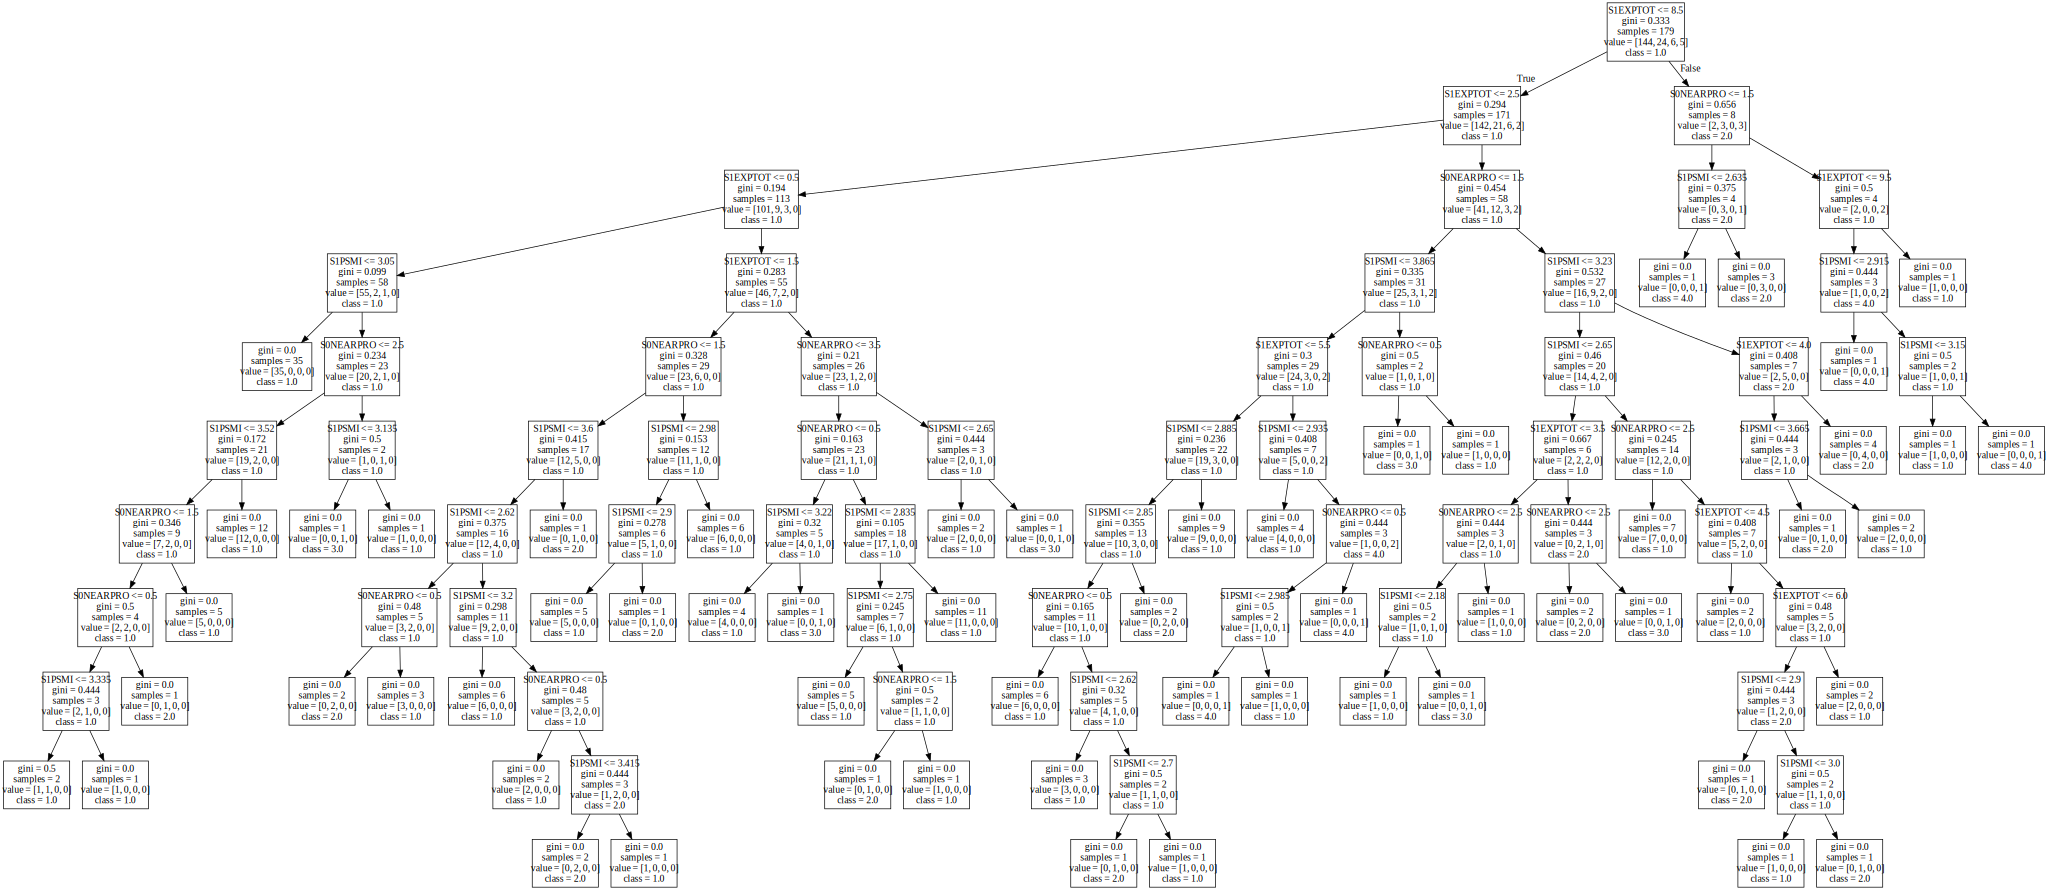

In [26]:
## Decision Tree Select Model Rendering - 6-month cohort

graph = treeplot(selectmodelS1, XselectS1, PolConSelectS1, "SelectModelS1")
graph
# dot_data = tree.export_graphviz(selectmodelS1, out_file=None,
#                                feature_names=XselectS1.columns,
#                                class_names=np.sort(PolConSelectS1.unique()))
#                                #class_names=PolConSelect)
#                                #class_names=['0','1','2','3','4'])
#                                #class_names=True)
# graph = gv.Source(dot_data)
# graph.render("SelectModelS1")
# graph

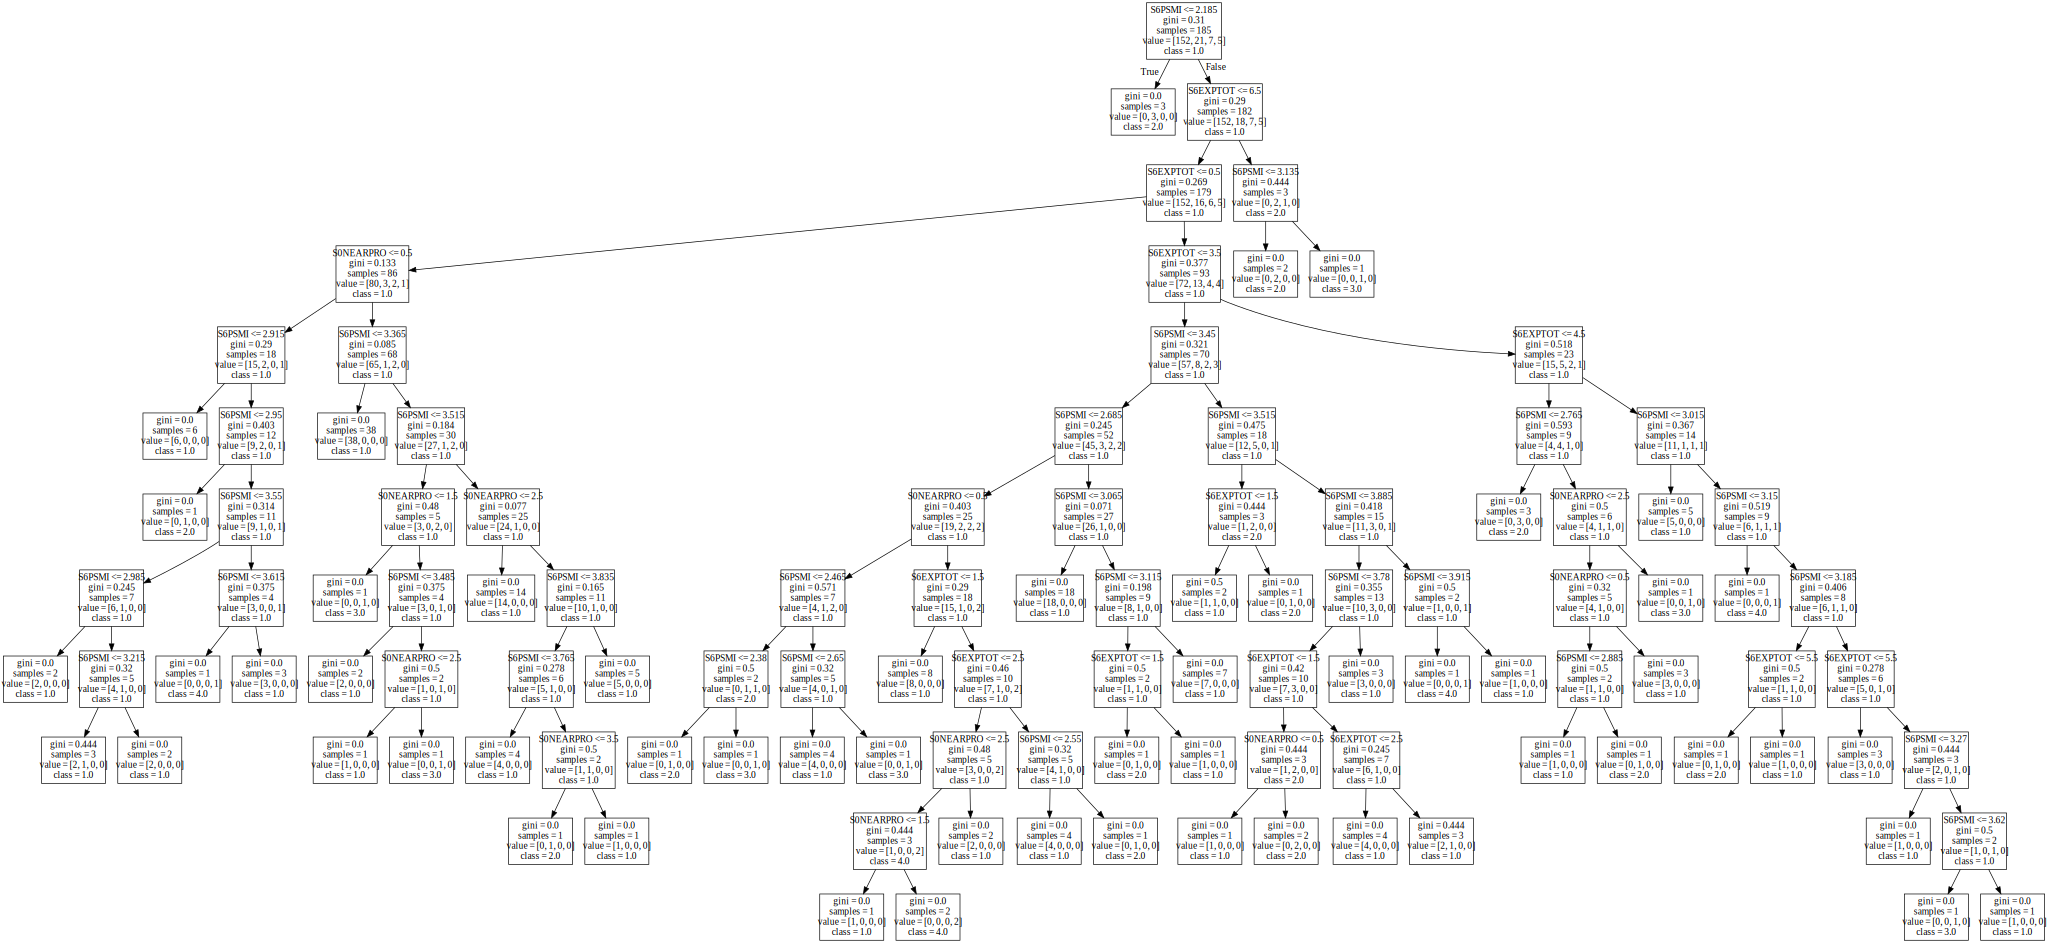

In [27]:
## Decision Tree Select Model Rendering - 36-month cohort
graph = treeplot(selectmodelS6, XselectS6, PolConSelectS6, "SelectModelS6")
graph

# dot_data = tree.export_graphviz(selectmodelS6, out_file=None,
#                                feature_names=XselectS6.columns,
#                                class_names=np.sort(PolConSelectS6.unique()))
#                                #class_names=PolConSelect)
#                                #class_names=['0','1','2','3','4'])
#                                #class_names=True)
# graph = gv.Source(dot_data)
# graph.render("SelectModelS6")
# graph

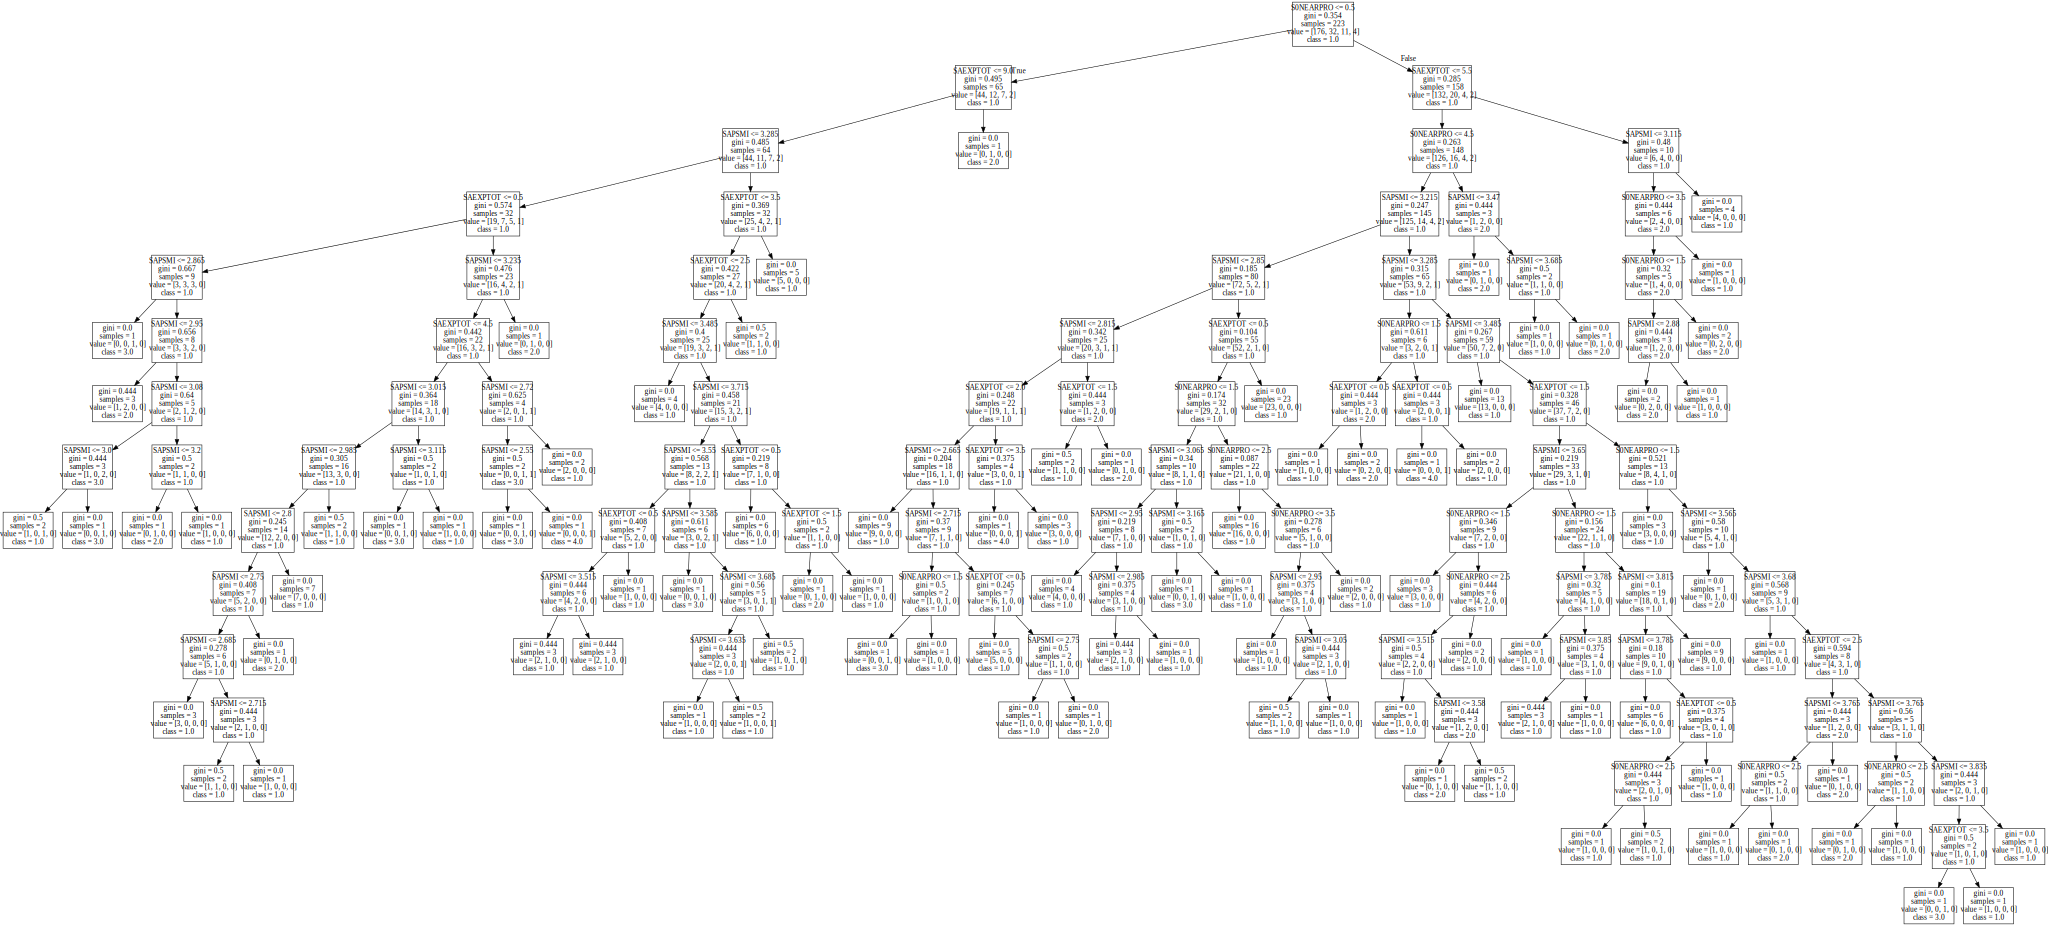

In [28]:
## Decision Tree Select Model Rendering - 84-month cohort
graph = treeplot(selectmodelSA, XselectSA, PolConSelectSA, "SelectModelSA")
graph

# dot_data = tree.export_graphviz(selectmodelSA, out_file=None,
#                                feature_names=XselectSA.columns,
#                                class_names=np.sort(PolConSelectSA.unique()))
#                                #class_names=PolConSelect)
#                                #class_names=['0','1','2','3','4'])
#                                #class_names=True)
# graph = gv.Source(dot_data)
# graph.render("SelectModelSA")
# graph

           Importance       Name
S1EXPTOT     0.221823   S1EXPTOT
S0NEARPRO    0.262358  S0NEARPRO
S1PSMI       0.515819     S1PSMI
           Importance       Name
S0NEARPRO    0.186258  S0NEARPRO
S6EXPTOT     0.234361   S6EXPTOT
S6PSMI       0.579381     S6PSMI
           Importance       Name
S0NEARPRO    0.194219  S0NEARPRO
SAEXPTOT     0.256649   SAEXPTOT
SAPSMI       0.549132     SAPSMI


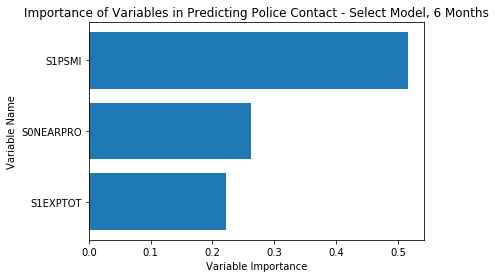

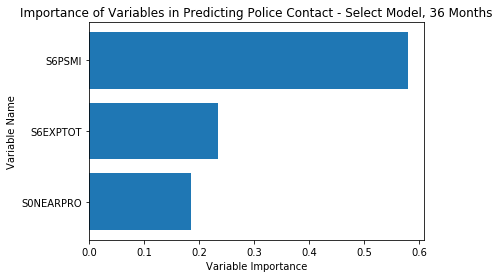

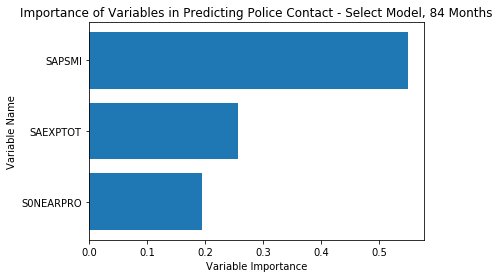

In [29]:
# Feature Importance Graphs - Select Model Decision Trees

featimpbar(selectmodelS1, XselectS1, 'Importance of Variables in Predicting Police Contact - Select Model, 6 Months')
featimpbar(selectmodelS6, XselectS6, 'Importance of Variables in Predicting Police Contact - Select Model, 36 Months')
featimpbar(selectmodelSA, XselectSA, 'Importance of Variables in Predicting Police Contact - Select Model, 84 Months')


           Importance       Name
S0NEARPRO    0.189828  S0NEARPRO
S1EXPTOT     0.321559   S1EXPTOT
S1PSMI       0.488613     S1PSMI
           Importance       Name
S0NEARPRO    0.102015  S0NEARPRO
S6EXPTOT     0.309583   S6EXPTOT
S6PSMI       0.588402     S6PSMI
           Importance       Name
S0NEARPRO    0.160878  S0NEARPRO
SAEXPTOT     0.223846   SAEXPTOT
SAPSMI       0.615276     SAPSMI


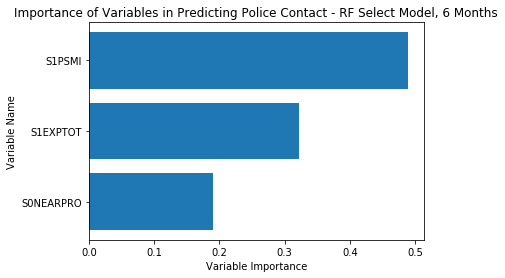

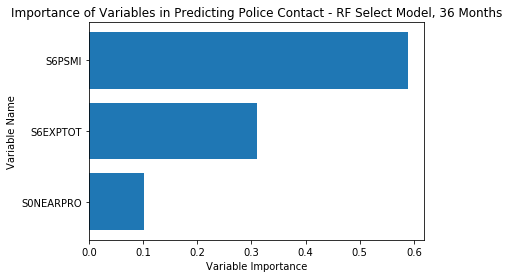

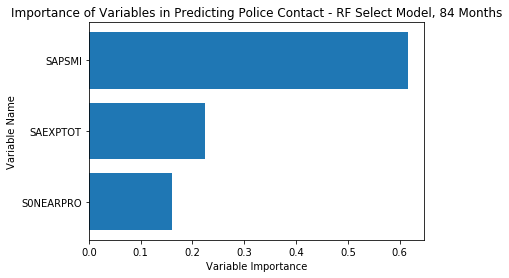

In [30]:
# Feature Importance Graphs - Random Forest Model, Select Model

featimpbar(randomselectS1, XselectS1, 'Importance of Variables in Predicting Police Contact - RF Select Model, 6 Months')
featimpbar(randomselectS6, XselectS6, 'Importance of Variables in Predicting Police Contact - RF Select Model, 36 Months')
featimpbar(randomselectSA, XselectSA, 'Importance of Variables in Predicting Police Contact - RF Select Model, 84 Months')
